In [22]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

In [13]:
tradingPairs = {'JBF':'3443','QWF':'2388','HCF':'2498','DBF':'2610','EHF':'1319','IPF':'3035','IIF':'3006','QXF':'2615','PEF':'5425','NAF':'3105'}

In [16]:
stockPath = "../tickData/stocks"
stockFiles = os.listdir(stockPath)
futuresPath = "../tickData/futuresOB"
futuresFiles = os.listdir(futuresPath)
stockFiles.remove('.DS_Store')
futuresFiles.remove('.DS_Store')

In [17]:
stockData = {}
futuresData = {}
for file in stockFiles:
  stockData[file] = os.listdir(stockPath + '/' + file)
for file in futuresFiles:
  futuresData[file] = os.listdir(futuresPath + '/' + file)

In [18]:
stockPriceOneMinute = {}
futuresPriceOneMinute = {}

In [23]:
for stock in tqdm(stockData.keys()):
  stockPriceOneMinute[stock] = pd.DataFrame()
  for date in stockData[stock]:
    stockTick = pd.read_csv(stockPath + '/' + stock + '/' + date, compression='gzip')
    #Data processing
    stockTick = stockTick[['date','time','SP1','BP1']].dropna()
    stockTick = stockTick.loc[stockTick['SP1'] * stockTick['BP1'] != 0]
    stockTick['midQuote'] = np.log(stockTick[['SP1','BP1']].mean(axis=1))
    # past 5 min average
    stockTick['time'] = (stockTick['time'] +(500000- stockTick['time'] % 500000)) / 100000
    stockPrice = stockTick[['date','time','midQuote']]
    stockPrice_ = stockPrice.groupby(['date','time'])['midQuote'].mean()
    frames = [stockPriceOneMinute[stock], stockPrice_]
    stockPriceOneMinute[stock] = pd.concat(frames)

100%|██████████| 10/10 [06:50<00:00, 41.06s/it]


In [24]:
stockPriceOneMinute

{'2610':                              0
 (2021-01-04, 905.0)   7.085059
 (2021-01-04, 910.0)   7.082524
 (2021-01-04, 915.0)   7.080253
 (2021-01-04, 920.0)   7.069086
 (2021-01-04, 925.0)   7.069425
 ...                        ...
 (2020-08-31, 1305.0)  6.759672
 (2020-08-31, 1310.0)  6.759575
 (2020-08-31, 1315.0)  6.758770
 (2020-08-31, 1320.0)  6.759022
 (2020-08-31, 1325.0)  6.758656
 
 [19565 rows x 1 columns],
 '3105':                               0
 (2021-07-01, 905.0)   10.539400
 (2021-07-01, 910.0)   10.537517
 (2021-07-01, 915.0)   10.536501
 (2021-07-01, 920.0)   10.535168
 (2021-07-01, 925.0)   10.535526
 ...                         ...
 (2021-10-29, 1060.0)  10.479087
 (2021-10-29, 1105.0)  10.478926
 (2021-10-29, 1110.0)  10.479344
 (2021-10-29, 1115.0)  10.480751
 (2021-10-29, 1120.0)  10.481948
 
 [23393 rows x 1 columns],
 '1319':                              0
 (2020-10-05, 905.0)   8.187993
 (2020-10-05, 910.0)   8.193085
 (2020-10-05, 915.0)   8.194359
 (2020-10-

In [25]:
for futures in tqdm(futuresData.keys()):
  futuresPriceOneMinute[futures] = pd.DataFrame()
  for date in futuresData[futures]:
    futuresTick = pd.read_csv(futuresPath + '/' + futures + '/' + date)
    #Data processing
    futuresTick = futuresTick[['date','time','askPrice1','bidPrice1']].dropna()
    futuresTick = futuresTick.loc[futuresTick['askPrice1'] * futuresTick['bidPrice1'] != 0]
    futuresTick['midQuote'] = np.log(futuresTick[['askPrice1','bidPrice1']].mean(axis=1))
    # past 5 min average
    futuresTick['time'] = (futuresTick['time'] + (500000 - futuresTick['time'] % 500000)) / 100000
    futuresPrice = futuresTick[['date','time','midQuote']]
    futuresPrice_ = futuresPrice.groupby(['date','time'])['midQuote'].mean()
    frames = [futuresPriceOneMinute[futures], futuresPrice_]
    futuresPriceOneMinute[futures] = pd.concat(frames)

100%|██████████| 10/10 [01:34<00:00,  9.45s/it]


In [26]:
futuresPriceOneMinute

{'IPF':                               0
 (2022-01-03, 850.0)   10.078170
 (2022-01-03, 855.0)   10.075684
 (2022-01-03, 860.0)   10.074769
 (2022-01-03, 905.0)   10.079376
 (2022-01-03, 910.0)   10.075199
 ...                         ...
 (2021-12-30, 1325.0)  10.079125
 (2021-12-30, 1330.0)  10.077744
 (2021-12-30, 1335.0)  10.079717
 (2021-12-30, 1340.0)  10.078491
 (2021-12-30, 1345.0)  10.077362
 
 [23682 rows x 1 columns],
 'HCF':                              0
 (2020-09-01, 850.0)   8.020617
 (2020-09-01, 855.0)   8.020332
 (2020-09-01, 860.0)   8.018789
 (2020-09-01, 905.0)   8.013317
 (2020-09-01, 910.0)   8.010273
 ...                        ...
 (2022-08-31, 1325.0)  8.729818
 (2022-08-31, 1330.0)  8.728688
 (2022-08-31, 1335.0)  8.733183
 (2022-08-31, 1340.0)  8.736007
 (2022-08-31, 1345.0)  8.736493
 
 [43168 rows x 1 columns],
 'DBF':                              0
 (2022-08-31, 850.0)   7.708260
 (2022-08-31, 855.0)   7.706721
 (2022-08-31, 860.0)   7.705261
 (2022-08-31,

In [27]:
spreads = {}
for futures in futuresData.keys():
  spreads[futures] = (stockPriceOneMinute[tradingPairs[futures]] - futuresPriceOneMinute[futures]).dropna()


In [33]:
for name in spreads.keys():
  spreads[name].to_csv('../tickData/spreadData/' + name + '_spread.csv')

In [31]:
from matplotlib import pyplot
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

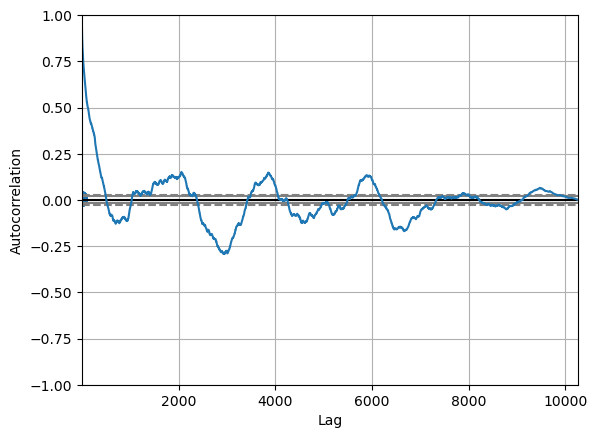

In [34]:
series = pd.read_csv('../tickData/spreadData/DBF_spread.csv', header=0, index_col=0)
lag_plot(series)
autocorrelation_plot(series)
pyplot.show()